In [1]:
import pandas as pd

# Loading the dataset
file_path = '/Users/pritam/Documents/SNU-Study-Buddy-Finder/Data Collection for ML mini project (Responses) - Form Responses 1.csv'
df = pd.read_csv(file_path)

# Create a mapping dictionary programmatically by matching keywords. The messy column names with extra spaces or characters will be handled.
column_mapping = {}
for col in df.columns:
    clean_col = col.strip().lower()
    if 'teamwork preference' in clean_col:
        column_mapping[col] = 'teamwork_preference'
    elif 'introversion extraversion' in clean_col:
        column_mapping[col] = 'introversion_extraversion'
    elif 'books read past year' in clean_col:
        column_mapping[col] = 'books_read_past_year'
    elif 'club top1' in clean_col:
        column_mapping[col] = 'club_top1'
    elif 'weekly_hobby_hours' in clean_col:
        column_mapping[col] = 'weekly_hobby_hours'

# Selecting only the relevant columns based on the new, clean names
df.rename(columns=column_mapping, inplace=True)

# Select only the relevant columns based on the new, clean names
relevant_columns = list(column_mapping.values())
df_buddy = df[relevant_columns].copy()

# Displaying the first few rows to confirm the column names are now correct
print("\nDataFrame after cleaning and selecting columns:")
df_buddy.head()


DataFrame after cleaning and selecting columns:


,books_read_past_year,club_top1,weekly_hobby_hours,introversion_extraversion,teamwork_preference
0,0,Robotics Club,0,2,3
1,2,Coding Club,40,3,3
2,5,Coding Club,5,3,3
3,5,Entrepreneurship Cell,10,5,5
4,5,Literary Club,5,3,1


In [2]:
# Defining a function to clean numeric columns with inconsistent data
def clean_numeric_column(series):
    cleaned_series = (
        series.astype(str)
        .str.strip().str.lower()
    )
    cleaned_series = cleaned_series.str.split('-').str[0]
    cleaned_series = pd.to_numeric(cleaned_series, errors='coerce').fillna(0).astype(int)
    return cleaned_series

# Applying the above defined cleaning function to the relevant columns
df_buddy['books_read_past_year'] = clean_numeric_column(df_buddy['books_read_past_year'])
df_buddy['weekly_hobby_hours'] = clean_numeric_column(df_buddy['weekly_hobby_hours'])


In [10]:
# Here we are applying One-Hot Encoding to the categorical feature to convert it into numerical format
df_encoded = pd.get_dummies(df_buddy, columns=['club_top1'], prefix='club', dtype=int)


In [11]:
from sklearn.preprocessing import StandardScaler
# Importing the Standard Scalar Tool

# Identifying the numerical columns
numeric_cols = ['teamwork_preference', 'introversion_extraversion',
                'books_read_past_year', 'weekly_hobby_hours']

scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


In [12]:
from sklearn.metrics.pairwise import cosine_similarity
# Importing the Cosine Similarity Function

# Computing the similarity matrix
# This calculates a similarity score for every pair of students in the dataset
similarity_matrix = cosine_similarity(df_encoded)
print("Similarity matrix shape:", similarity_matrix.shape)


Similarity matrix shape: (111, 111)


In [13]:
# Function to get top K recommended buddies
def recommend_buddies(student_id, k=5):
    similarities = list(enumerate(similarity_matrix[student_id]))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    top_buddies = [i for i, sim in similarities[1:k+1]]
    return top_buddies


In [14]:
# Function to define 'relevant' buddies for evaluation

def get_relevant_buddies(student_id, df):
    relevant = []
    for other_id in range(len(df)):
        if student_id == other_id:
            continue
        
        same_club = df.loc[student_id, 'club_top1'] == df.loc[other_id, 'club_top1']
        teamwork_close = abs(df.loc[student_id, 'teamwork_preference'] - df.loc[other_id, 'teamwork_preference']) <= 1
        introvert_close = abs(df.loc[student_id, 'introversion_extraversion'] - df.loc[other_id, 'introversion_extraversion']) <= 1

        if same_club or teamwork_close or introvert_close:
            relevant.append(other_id)
    return relevant


In [15]:
# Functions to calculate evaluation metrics

def precision_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / k if k > 0 else 0

def recall_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / len(relevant) if len(relevant) > 0 else 0


In [16]:
# Function to run the full evaluation across all students

def evaluate_recommendation_system(df, recommend_func, k=5):
    precision_scores = []
    recall_scores = []

    for student_id in range(len(df)):
        recommended = recommend_func(student_id, k)
        relevant = get_relevant_buddies(student_id, df)

        if len(relevant) == 0:
            continue  # skip if no relevant buddies exist

        precision_scores.append(precision_at_k(recommended, relevant, k))
        recall_scores.append(recall_at_k(recommended, relevant, k))

    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)

    print(f"📊 Evaluation Results (K={k})")
    print(f"Average Precision@{k}: {avg_precision:.3f}")
    print(f"Average Recall@{k}: {avg_recall:.3f}")

    return avg_precision, avg_recall


In [17]:
# Run the evaluation
evaluate_recommendation_system(df_buddy, recommend_buddies, k=5)

📊 Evaluation Results (K=5)
Average Precision@5: 0.998
Average Recall@5: 0.054


(0.9981981981981982, 0.0539867164645442)

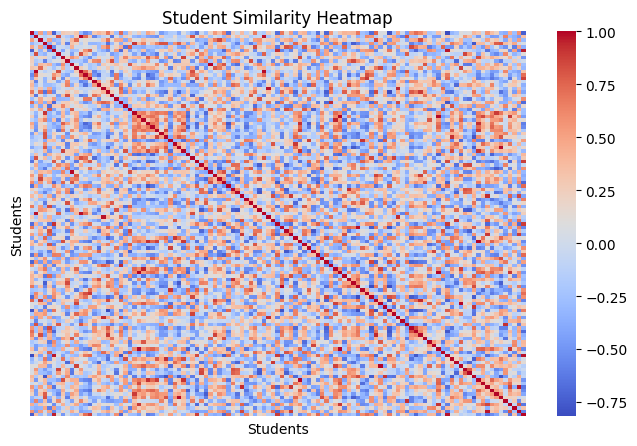

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of similarity matrix
plt.figure(figsize=(8, 5))
sns.heatmap(similarity_matrix, cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("Student Similarity Heatmap")
plt.xlabel("Students")
plt.ylabel("Students")
plt.show()


📊 Evaluation Results (K=1)
Average Precision@1: 1.000
Average Recall@1: 0.011
📊 Evaluation Results (K=2)
Average Precision@2: 1.000
Average Recall@2: 0.022
📊 Evaluation Results (K=3)
Average Precision@3: 1.000
Average Recall@3: 0.032
📊 Evaluation Results (K=4)
Average Precision@4: 1.000
Average Recall@4: 0.043
📊 Evaluation Results (K=5)
Average Precision@5: 0.998
Average Recall@5: 0.054
📊 Evaluation Results (K=6)
Average Precision@6: 0.998
Average Recall@6: 0.065
📊 Evaluation Results (K=7)
Average Precision@7: 0.999
Average Recall@7: 0.076
📊 Evaluation Results (K=8)
Average Precision@8: 0.998
Average Recall@8: 0.086
📊 Evaluation Results (K=9)
Average Precision@9: 0.996
Average Recall@9: 0.097
📊 Evaluation Results (K=10)
Average Precision@10: 0.993
Average Recall@10: 0.107
📊 Evaluation Results (K=11)
Average Precision@11: 0.992
Average Recall@11: 0.118
📊 Evaluation Results (K=12)
Average Precision@12: 0.990
Average Recall@12: 0.129
📊 Evaluation Results (K=13)
Average Precision@13: 0.988

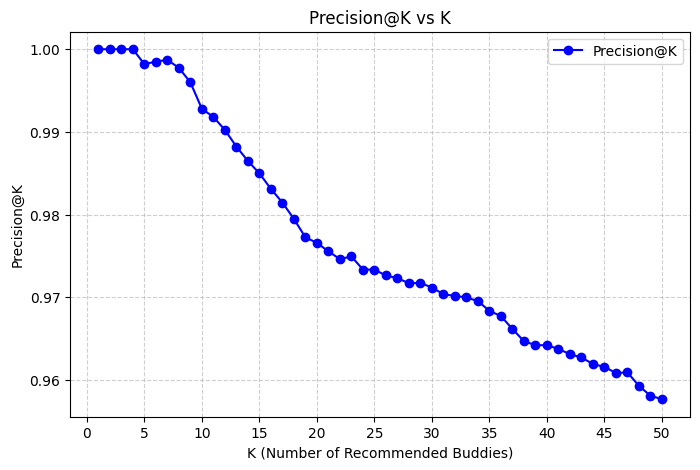

In [19]:
import matplotlib.pyplot as plt

def plot_precision_at_k(df, recommend_func, max_k=100):
    precisions = []
    ks = list(range(1, max_k + 1))

    for k in ks:
        avg_precision, _ = evaluate_recommendation_system(df, recommend_func, k=k)
        precisions.append(avg_precision)

    # Plot Precision@K
    plt.figure(figsize=(8, 5))
    plt.plot(ks, precisions, marker='o', linestyle='-', color='b', label='Precision@K')
    plt.xlabel("K (Number of Recommended Buddies)")
    plt.ylabel("Precision@K")
    plt.title("Precision@K vs K")
    plt.xticks(range(0, max_k+1, 5))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

plot_precision_at_k(df_buddy, recommend_buddies, max_k=50)
